# Task Overview

Your task will be to implement a *RevNet* (Reversible Residual Network) – a variant of ResNet where each layer's activations can be reconstructed exactly from the next layer. Therefore, the activations for most layers need not be stored in memory to perform backpropagation.

You can find more information about RevNet here: [link](https://arxiv.org/pdf/1707.04585.pdf)

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (10pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 2pt implement the mini-batch update
  - 5pt implement the backpropagation (note: if you implement backpropagation example-by-example instead of whole minibatch at once, you will get maximum of 2pt for this part)
2. Train the models (find proper hyperparameters). Visualize training of your best model (plot training and test loss/accuracy in time). Your model should reach at least 96% accuracy. Use clear ml for logging your scores. Make a comparison of memory usage for your network and the network you implemented in lab 3.
  - 1pt for accuracy above 96%
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.



## Potential questions, clarifications
- Q: Can I save the output of the last layer before classification (a -> 10)?
  - Yes.
- Q: MNIST has only one channel, how do I split that into two groups for implementing ReVNet blocks?
  - You can split activations into two groups, so if a layer has size $a$ you can split it into $2 \cdot a/2$.
- Q: Can I modify code of ReVNet outside #Your code goes here # to include logging?
  - Yes, in ReVNet.SGD

# Imports

In [ ]:
!pip install clearml --quiet
!pip install memory-profiler --quiet

In [1]:
import random
import numpy as np
from torchvision import datasets, transforms
import plotly.express as px

In [2]:
%load_ext memory_profiler

# Dataset loading


In [5]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2023-11-25 21:08:42--  https://s3.amazonaws.com/img-datasets/mnist.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 

52.216.245.78, 52.217.142.192, 52.217.230.120, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.245.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz’

mnist.npz           100%[===================>]  10,96M   151KB/s    in 85s     

2023-11-25 21:10:24 (133 KB/s) - ‘mnist.npz’ saved [11490434/11490434]



In [3]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [4]:
### Your code goes here ###

from clearml import Task
task = Task.init(project_name='dnn_mimuw', task_name='revnet')
logger = task.get_logger()

###########################

ClearML Task: created new task id=72e6fb7fa473474d819faa2d7b969f07
2023-11-26 22:54:51,605 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/1801f60a804a4b128ae70e6afb5f4c0a/experiments/72e6fb7fa473474d819faa2d7b969f07/output/log


Retrying (Retry(total=237, connect=238, read=239, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f80ca37ed60>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /v2.23/events.add_batch
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f80ca321310>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /v2.23/tasks.get_all
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f80ca321bb0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution')': /v2.23/events.add_batch
Retrying (Retry(total=236, connect=237, read=239, redirect=240, status=240)) after connection bro

# Network definition (as in laboratory 3)


In [5]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


/home/wojtek/anaconda3/envs/torch/share/jupyter/nbconvert/templates/base/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  {%- elif type == 'text/vnd.mermaid' -%}


# ReVNet definition

RevNets are composed of a series of reversible blocks. The channels (in case of MNIST: activations) in each layer are partitioned into two groups (two vectors), denoted $x_1$ and $x_2$.

Forward: Each reversible block takes inputs ($x_1$, $x_2$) and produces outputs produces outputs ($y_1$, $y_2$) using functions F and G (the *residuals*). In this task, implement F and G as MLP layers.

$z_1 = x_1 + \mathcal{F}(x_2)$

$y_2 = x_2 + \mathcal{G}(z_1)$

$y_1 = z_1$

The expressions $y_1$ and $z_1$ have the same value, but they are separate nodes in the computation graph, with $y_2$ depending on $z_1$, not $y_1$. We use this distinction so that we can describe gradient computations in two steps: $∂ℒ/∂y_1$ is the derivative of the loss over $y_1$ when $y_2$ is a fixed constant, while $∂ℒ/∂z_1$ is the derivative over $z_1$, which influences the loss through both y1 and y2.

Reverse: Each layer’s activations can be reconstructed from the next layer’s activations as follows:

$x_2 = y_2 - \mathcal{G}(y_1)$

$x_1 = y_1 - \mathcal{F}(x_2)$

Backpropagation is described in the algorithm below, ($y_1$, $y_2$).
$\bar{y_1}$, $\bar{y_2}$ is the gradient of the loss over $y_1$ and $y_2$, respectively


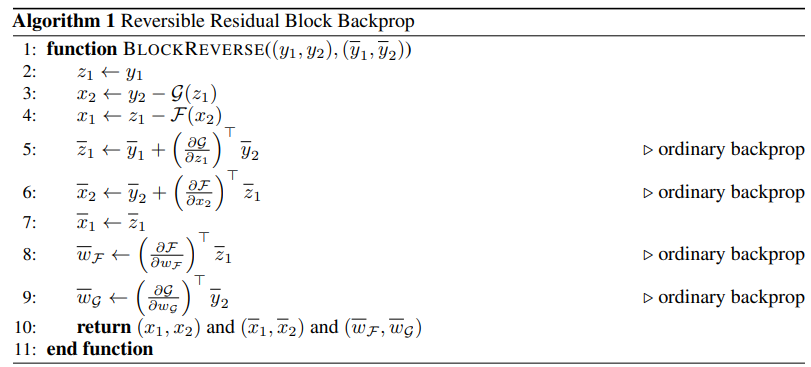

In [6]:
def softmax(x):
  ### Your code goes here ###
  m = np.max(x)
  if np.isnan(np.exp(x - m) / np.sum(np.exp(x - m), axis=0)).any():
    print("nan!", np.sum(np.exp(x - m), axis=0))
  return np.exp(x - m) / np.sum(np.exp(x - m), axis=0)
  ###########################

def cross_entropy(x, y):
  ### Your code goes here ###
  return -np.sum(y * np.log(x + 1e-5) + (1 - y) * np.log(1 - x + 1e-5), axis=0)
  ###########################

class ReVNet(object):
  def __init__(self, sizes):
    self.sizes = sizes
    # initialize biases and weights with random normal distr.
    # weights are indexed by target node first
    # sizes should be in form (mnist_size, a, a, a, ...,  a, 10)
    # IMPORTANT: use at least one layer of size a -> a
    ### Your code goes here ###
    entry_size = sizes[0]
    middle_size = sizes[1]
    output_size = sizes[-1]

    self.w_entry = np.random.randn(middle_size, entry_size) / np.sqrt(entry_size)
    self.b_entry = np.random.randn(middle_size, 1)
    self.w_fgs = np.random.randn(len(sizes) - 3, 2, middle_size // 2, middle_size // 2) / np.sqrt(middle_size // 2)
    self.b_fgs = np.random.randn(len(sizes) - 3, 2, middle_size // 2, 1)
    self.w_exit = np.random.randn(output_size, middle_size) / np.sqrt(middle_size)
    self.b_exit = np.random.randn(output_size, 1)
    
    def sigmoid(x):
      s = 1.0/(1.0+np.exp(-x))
      return s, s*(1 - s)
    
    def relu(x):
      return np.maximum(0, x), (x > 0).astype(int)
    
    self.activation = sigmoid

    def block_forward(activation, x1, x2, wf, bf, wg, bg):
      f_res, _ = activation(np.matmul(wf, x2) + bf)
      y1 = f_res + x1
      g_res, _ = activation(np.matmul(wg, y1) + bg)
      y2 = x2 + g_res
      return y1, y2
    
    def block_reverse(activation, y1, y2, dLdy1, dLdy2, wf, bf, wg, bg):
      z1 = y1
      g_res, g_res_prime = activation(np.matmul(wg, z1) + bg)
      x2 = y2 - g_res
      f_res, f_res_prime = activation(np.matmul(wf, x2) + bf)
      x1 = z1 - f_res
      dLdz1 = dLdy1 + np.matmul(wg.T, dLdy2 * g_res_prime)
      dLdx2 = dLdy2 + np.matmul(wf.T, dLdz1 * f_res_prime)
      dLdx1 = dLdz1
      dLdwf = np.matmul(dLdz1 * f_res_prime, x2.T)
      dLdbf = np.sum(dLdz1 * f_res_prime, axis=1).reshape(-1, 1)
      dLdwg = np.matmul(dLdy2 * g_res_prime, z1.T)
      dLdbg = np.sum(dLdy2 * f_res_prime, axis=1).reshape(-1, 1)
      return x1, x2, dLdx1, dLdx2, np.array([dLdwf, dLdwg]), np.array([dLdbf, dLdbg])

    self.block_forward = block_forward
    self.block_reverse = block_reverse

    ###########################

  def feedforward(self, a):
    # Run the network
    ### Your code goes here ###
    x, _ = self.activation(np.matmul(self.w_entry, a.T) + self.b_entry)
    
    x1, x2 = np.split(x, 2)
    for w_fg, b_fg in zip(self.w_fgs, self.b_fgs):
      w_f, w_g = w_fg
      b_f, b_g = b_fg
      x1, x2 = self.block_forward(self.activation, x1, x2, w_f, b_f, w_g, b_g)

    x = np.concatenate((x1, x2))
    z = np.matmul(self.w_exit, x) + self.b_exit
    return softmax(z)

    ##########################

  def update_mini_batch(self, x_mini_batch, y_mini_batch, eta, verb=False):
    # Update networks weights and biases by applying a single step
    # of gradient descent using backpropagation to compute the gradient.
    # The gradient is computed for a mini_batch.
    # eta is the learning rate
    ### Your code goes here ###

    n_samples = x_mini_batch.shape[0]
    
    delta_entry, delta_exit, (dLdb_fgs, dLdw_fgs) = self.backpropagation(x_mini_batch.T,y_mini_batch.T)
    self.b_entry -= delta_entry[0] * eta / n_samples
    self.w_entry -= delta_entry[1] * eta / n_samples
    self.b_exit  -= delta_exit[0] * eta / n_samples
    self.w_exit  -= delta_exit[1] * eta / n_samples
    self.w_fgs -= dLdw_fgs * eta / n_samples
    self.b_fgs -= dLdb_fgs * eta / n_samples

    ###########################


  def backpropagation(self, x, y):
    ### Your code goes here ###
    input = x
    dLdw_fgs = np.zeros(self.w_fgs.shape)
    dLdb_fgs = np.zeros(self.b_fgs.shape)

    z_entry = np.matmul(self.w_entry, input) + self.b_entry
    x, dgdf_z_entry = self.activation(z_entry)

    x1, x2 = np.split(x, 2)
    for w_fg, b_fg in zip(self.w_fgs, self.b_fgs):
      w_f, w_g = w_fg
      b_f, b_g = b_fg
      x1, x2 = self.block_forward(self.activation, x1, x2, w_f, b_f, w_g, b_g)
    
    x = np.concatenate((x1, x2))
    z_exit = np.matmul(self.w_exit, x) + self.b_exit

    dLdz_exit = self.cost_derivative(softmax(z_exit), y)
    
    dLdw_exit = np.matmul(dLdz_exit, x.T)
    dLdb_exit = dLdz_exit.sum(axis=1).reshape(-1, 1)

    dLdx = np.matmul(self.w_exit.T, dLdz_exit)
    dLdx1, dLdx2 = np.split(dLdx, 2)
    for w_fg, b_fg, i in reversed(list(zip(self.w_fgs, self.b_fgs, np.arange(len(self.w_fgs))))):
      w_f, w_g = w_fg
      b_f, b_g = b_fg
      x1, x2, dLdx1, dLdx2, dLdw_fg, dLdb_fg = self.block_reverse(self.activation, x1, x2, dLdx1, dLdx2, w_f, b_f, w_g, b_g)
      dLdw_fgs[i] = dLdw_fg
      dLdb_fgs[i] = dLdb_fg

    dLdz_entry = np.concatenate((dLdx1, dLdx2)) * dgdf_z_entry
    dLdw_entry = np.matmul(dLdz_entry, input.T)
    dLdb_entry = dLdz_entry.sum(axis=1).reshape(-1, 1)

    return (dLdb_entry, dLdw_entry), (dLdb_exit, dLdw_exit), (dLdb_fgs, dLdw_fgs)
    ###########################

  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

  def evaluate(self, x_test_data, y_test_data):
    # Count the number of correct answers for test_data
    y_pred = self.feedforward(x_test_data)
    loss = np.mean(cross_entropy(y_pred, y_test_data.T))

    pred = np.argmax(y_pred, axis=0)
    corr = np.argmax(y_test_data,axis=1).T
    acc = np.mean(pred==corr)
    
    return acc, loss


  def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []
    task.set_parameters({
      "sizes": self.sizes,
      "epochs": epochs,
      "mini_batch_size": mini_batch_size,
      "eta": eta,
    })

    x_train, y_train = training_data
    if test_data:
        x_test, y_test = test_data
    for j in range(epochs):
        for i in range(x_train.shape[0] // mini_batch_size):
            x_mini_batch = x_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
            y_mini_batch = y_train[i*mini_batch_size:(i*mini_batch_size + mini_batch_size)]
            self.update_mini_batch(x_mini_batch, y_mini_batch, eta)
        if test_data:
            train_acc, train_loss = self.evaluate(x_train, y_train)
            test_acc, test_loss = self.evaluate(x_test, y_test)

            test_losses.append(test_loss)
            train_losses.append(train_loss)
            test_accuracies.append(test_acc)
            train_accuracies.append(train_acc)

            logger.report_scalar(title="loss", series="train_loss", value=train_loss, iteration=j)
            logger.report_scalar(title="loss", series="test_loss", value=test_loss, iteration=j)
            logger.report_scalar(title="accuracy", series="train_acc", value=train_acc, iteration=j)
            logger.report_scalar(title="accuracy", series="test_acc", value=test_acc, iteration=j)

            print("Epoch: {0}, Accuracy: {1}".format(j, test_acc))
        else:
            print("Epoch: {0}".format(j))
    
  
    return train_losses, test_losses, train_accuracies, test_accuracies


# Train the network

In [7]:
### Your code goes here ###

network = ReVNet([784, 40, 40, 10])
train_losses, test_losses, train_accuracies, test_accuracies = network.SGD((x_train, y_train), epochs=20, mini_batch_size=100, eta=1, test_data=(x_test, y_test))

# plotply loss in one chart
fig = px.line()
fig.add_scatter(x=np.arange(len(train_losses)), y=train_losses, name="Train loss")
fig.add_scatter(x=np.arange(len(test_losses)), y=test_losses, name="Test loss")
fig.show()

# plotply accuracy in one chart
fig = px.line()
fig.add_scatter(x=np.arange(len(train_accuracies)), y=train_accuracies, name="Train accuracy")
fig.add_scatter(x=np.arange(len(test_accuracies)), y=test_accuracies, name="Test accuracy")
fig.show()

###########################

Epoch: 0, Accuracy: 0.9196
Epoch: 1, Accuracy: 0.9395
Epoch: 2, Accuracy: 0.95
Epoch: 3, Accuracy: 0.9542
Epoch: 4, Accuracy: 0.9579
Epoch: 5, Accuracy: 0.9603
Epoch: 6, Accuracy: 0.9617
Epoch: 7, Accuracy: 0.9639
Epoch: 8, Accuracy: 0.9645
Epoch: 9, Accuracy: 0.9656
Epoch: 10, Accuracy: 0.9662
Epoch: 11, Accuracy: 0.9659
Epoch: 12, Accuracy: 0.9653
Epoch: 13, Accuracy: 0.9661
Epoch: 14, Accuracy: 0.9659
Epoch: 15, Accuracy: 0.9658
Epoch: 16, Accuracy: 0.9658
Epoch: 17, Accuracy: 0.9653
Epoch: 18, Accuracy: 0.9648
Epoch: 19, Accuracy: 0.9648


# Training plots for the best training


Link to clear_ml: https://app.clear.ml/projects/1801f60a804a4b128ae70e6afb5f4c0a/experiments/ad0a825653ad42eaa885f02c042d6652/output/execution

Hyperparameters used for the best training:
```
epochs: 20	
eta: 1
mini_batch_size: 100	
sizes: [784, 40, 40, 10]	
```

![title](HW_1_accuracy.png)
![title](HW_1_loss.png )

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [8]:
 ### Your code goes here ###

import gc
import ctypes


def revnet_demo():
    network = ReVNet([784, 100, 100, 100, 100, 100, 100, 100, 10])
    _ = network.SGD((x_train, y_train), epochs=1, mini_batch_size=10000, eta=0.001)

def classic_net_demo():
    network = Network([784, 100, 100, 100, 100, 100, 100, 100, 10])
    _ = network.SGD((x_train, y_train), epochs=1, mini_batch_size=10000, eta=0.001)


print("Reversible neural network: ")

gc.collect()
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

%memit revnet_demo()

print("Classic neural network: ")

gc.collect()
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

%memit classic_net_demo()

###########################

Reversible neural network: 
Epoch: 0
peak memory: 987.69 MiB, increment: 88.09 MiB
Classic neural network: 
Epoch: 0
peak memory: 1152.84 MiB, increment: 251.73 MiB
